#### Importando bibliotecas

In [1]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import copy
import itertools
import os
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#### Funções necessárias para armazenar os dados e rodar o modelo

In [2]:
# Funções para carregar as imagens já pré-processadas e calcular os labels
def calculate_label(image, threshold=0.05):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(np.fliplr(data_right))
                patient_data["mask_right"].append(np.fliplr(data_msk_right))
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    print(f"Paciente {patient_id} carregado com sucesso.")
    total_recortes = len(patient_data["labels_left"]) + len(patient_data["labels_right"])
    print(f"Total de recortes: {total_recortes}")
    return patient_data

In [3]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

def augment_image(img_left, img_right, mask_left, mask_right):
    """
    Gera 7 variações (exceto a imagem original) aplicando:
    - rotação 180°
    - flip vertical
    - troca de lado
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    results_left = []
    masks_left = []
    results_right = []
    masks_right = []
    
    # Todas as combinações possíveis, exceto a (False, False, False)
    for rotate in [False, True]:
        for flip in [False, True]:
            for swap in [False, True]:
                if not (rotate or flip or swap):  # pula a imagem padrão
                    continue

                l_img = img_left.copy()
                r_img = img_right.copy()
                l_mask = mask_left.copy()
                r_mask = mask_right.copy()

                if rotate:
                    l_img = rotate_180(l_img)
                    r_img = rotate_180(r_img)
                    l_mask = rotate_180(l_mask)
                    r_mask = rotate_180(r_mask)

                if flip:
                    l_img = flip_vertical(l_img)
                    r_img = flip_vertical(r_img)
                    l_mask = flip_vertical(l_mask)
                    r_mask = flip_vertical(r_mask)

                if swap:
                    l_img, r_img = r_img, l_img
                    l_mask, r_mask = r_mask, l_mask

                results_left.append(l_img)
                masks_left.append(l_mask)
                results_right.append(r_img)
                masks_right.append(r_mask)

    return results_left, results_right, masks_left, masks_right

def augment_single_image(img_left, img_right, mask_left, mask_right, rng):
    """
    Aplica uma única modificação aleatória entre:
    - rotação 180°
    - flip vertical
    - troca de lado
    - combinações entre elas
    (7 variações possíveis)
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    # Lista de todas combinações possíveis (sem a identidade)
    transformations = [
        (True, False, False),   # só rotate
        (False, True, False),   # só flip
        (False, False, True),   # só swap
        (True, True, False),    # rotate + flip
        (True, False, True),    # rotate + swap
        (False, True, True),    # flip + swap
        (True, True, True)      # rotate + flip + swap
    ]

    # Escolhe aleatoriamente uma transformação
    rotate, flip, swap = rng.choice(transformations)

    l_img = img_left.copy()
    r_img = img_right.copy()
    l_mask = mask_left.copy()
    r_mask = mask_right.copy()

    if rotate:
        l_img = rotate_180(l_img)
        r_img = rotate_180(r_img)
        l_mask = rotate_180(l_mask)
        r_mask = rotate_180(r_mask)

    if flip:
        l_img = flip_vertical(l_img)
        r_img = flip_vertical(r_img)
        l_mask = flip_vertical(l_mask)
        r_mask = flip_vertical(r_mask)

    if swap:
        l_img, r_img = r_img, l_img
        l_mask, r_mask = r_mask, l_mask

    return l_img, r_img, l_mask, r_mask

# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images, all_labels):
    selected_images = {}
    selected_labels = []
    
    for patient in patients:
        selected_images[patient] = []
        if patient in all_images:
            selected_images[patient].extend(all_images[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images, selected_labels

In [4]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_left, labels_right, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels_left = {}
    balanced_labels_right = {}
    balanced_mask_left = {}
    balanced_mask_right = {}
    balanced_index_patients = {}

    # Separar os dados por conjunto (treino, validação, teste)
    train_patients = ['sub-02A13', 'sub-03C08', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16G09', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-22F14', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-51C05', 'sub-52K04', 'sub-57D04', 'sub-59G00', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    valid_patients = ['sub-00H10', 'sub-25B08', 'sub-29D03', 'sub-34J06', 'sub-56E13', 'sub-59E09', 'sub-60G06', 'sub-79H07']
    test_patients = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

    # patients = list(set(images_left.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size+0.01)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    print(len(train_patients) + len(valid_patients) + len(test_patients))
    
    class_1_left = {}
    class_0_left = {}
    class_1_right = {}
    class_0_right = {}
    class_1_mask_left = {}
    class_0_mask_left = {}
    class_1_mask_right = {}
    class_0_mask_right = {}
    class_1_coordinates = {}
    class_0_coordinates = {}

    for patient_id in images_left:
        class_1_labels_left = []
        class_0_labels_left = []
        class_1_labels_right = []
        class_0_labels_right = []
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        seed = hash(patient_id) % (2**32)  # Gera uma seed única por paciente
        rng = np.random.default_rng(seed)
        
        if len(labels_left[patient_id]) == 0 or len(labels_right[patient_id]) == 0:
            continue
        
        if patient_id in test_patients:
            balanced_images_left[patient_id] = images_left[patient_id]
            balanced_images_right[patient_id] = images_right[patient_id]
            balanced_labels_left[patient_id] = labels_left[patient_id]
            balanced_labels_right[patient_id] = labels_right[patient_id]
            balanced_mask_left[patient_id] = mask_left[patient_id]
            balanced_mask_right[patient_id] = mask_right[patient_id]
            continue
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        index = 0
        for label in labels_left[patient_id]:
            image_left = (images_left[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels_left.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_mask_left[patient_id].append(mask_image_left)
            else:
                class_0_labels_left.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_mask_left[patient_id].append(mask_image_left)
        
        index = 0
        for label in labels_right[patient_id]:
            image_right = (images_right[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels_right.append(label)
                class_1_right[patient_id].append(image_right)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels_right.append(label)
                class_0_right[patient_id].append(image_right)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels_left) + len(class_1_labels_right)
        class_0_count = len(class_0_labels_left) + len(class_0_labels_right)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 0: {class_0_count}")

        # Fazer Uppersampling da classe minoritária (label 1) para igualar ao número de exemplos da classe 0
        print(f"Paciente {patient_id}: Total de patches classe 1 antes do uppersampling: {class_1_count}")
        
        # Se a classe 1 for menor, aplicamos data augmentation
        if class_1_count < class_0_count:
            augmented_images_left = []
            augmented_images_right = []
            augmented_masks_left = []
            augmented_masks_right = []

            for idx, elem in enumerate(class_1_left[patient_id]):
                imgs_left_aug, imgs_right_aug, masks_left_aug, masks_right_aug = augment_image(class_0_left[patient_id][idx], class_0_right[patient_id][idx], class_0_mask_left[patient_id][idx], class_0_mask_right[patient_id][idx])
            
                augmented_images_left.extend(imgs_left_aug)
                augmented_images_right.extend(imgs_right_aug)
                augmented_masks_left.extend(masks_left_aug)
                augmented_masks_right.extend(masks_right_aug)

            # Adiciona os dados aumentados
            class_1_left[patient_id].extend(augmented_images_left)
            class_1_right[patient_id].extend(augmented_images_right)
            class_1_mask_left[patient_id].extend(augmented_masks_left)
            class_1_mask_right[patient_id].extend(augmented_masks_right)
            class_1_labels_left.extend([1] * (len(class_1_labels_left)*7))
            class_1_labels_right.extend([1] * (len(class_1_labels_right)*7))
            
        class_1_count = len(class_1_labels_left) + len(class_1_labels_right)
        print(f"Paciente {patient_id}: Total de patches classe 1 depois do uppersampling: {class_1_count}")
        
        augmented_class_0_left = []
        augmented_class_0_right = []
        augmented_class_0_mask_left = []
        augmented_class_0_mask_right = []

        i=0
        for img_left, img_right, mask_l, mask_r in zip(class_0_left[patient_id], class_0_right[patient_id], class_0_mask_left[patient_id], class_0_mask_right[patient_id]):
            # Decide aleatoriamente se vai aplicar augmentação
            seed = (hash(patient_id)+i) % (2**32)  # Gera uma seed única por paciente
            rng2 = np.random.default_rng(seed)
            if rng2.choice(2, 1, replace=False) < 1:
                aug_l, aug_r, aug_mask_l, aug_mask_r = augment_single_image(img_left, img_right, mask_l, mask_r, rng)
                augmented_class_0_left.append(aug_l)
                augmented_class_0_right.append(aug_r)
                augmented_class_0_mask_left.append(aug_mask_l)
                augmented_class_0_mask_right.append(aug_mask_r)
            else:
                # Mantém a original
                augmented_class_0_left.append(img_left)
                augmented_class_0_right.append(img_right)
                augmented_class_0_mask_left.append(mask_l)
                augmented_class_0_mask_right.append(mask_r)
            i+=1

        # Atualiza as listas da classe 0 com as versões modificadas
        class_0_left[patient_id] = augmented_class_0_left
        class_0_right[patient_id] = augmented_class_0_right
        class_0_mask_left[patient_id] = augmented_class_0_mask_left
        class_0_mask_right[patient_id] = augmented_class_0_mask_right
        
        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        # Calcula a contagem de amostras para cada classe no conjunto 'left'
        class_0_count_left = len(class_0_left[patient_id])
        class_1_count_left = len(class_1_left[patient_id])

        if class_0_count_left > class_1_count_left:
            # Caso 1.1: Classe 0 é majoritária no conjunto 'left', então fazemos undersampling dela
            print(f"Lado Esquerdo: Undersampling da Classe 0 de {class_0_count_left} para {class_1_count_left} amostras.")
            
            # Seleciona índices aleatórios da classe 0 para igualar à quantidade da classe 1
            sampled_indices = rng.choice(class_0_count_left, class_1_count_left, replace=False)
            
            # Cria novas listas com os dados amostrados
            sampled_images = [class_0_left[patient_id][i] for i in sampled_indices]
            sampled_masks = [class_0_mask_left[patient_id][i] for i in sampled_indices]
            
            # Atualiza as estruturas de dados originais com os dados amostrados
            class_0_left[patient_id] = sampled_images
            class_0_mask_left[patient_id] = sampled_masks
        else:
            # Caso 1.2: Classe 1 é majoritária (ou igual), então fazemos undersampling dela
            print(f"Lado Esquerdo: Undersampling da Classe 1 de {class_1_count_left} para {class_0_count_left} amostras.")
            
            # Seleciona índices aleatórios da classe 1 para igualar à quantidade da classe 0
            sampled_indices = rng.choice(class_1_count_left, class_0_count_left, replace=False)

            # Cria novas listas com os dados amostrados
            sampled_images = [class_1_left[patient_id][i] for i in sampled_indices]
            sampled_masks = [class_1_mask_left[patient_id][i] for i in sampled_indices]

            # Atualiza as estruturas de dados originais com os dados amostrados
            class_1_left[patient_id] = sampled_images
            class_1_mask_left[patient_id] = sampled_masks

        class_0_labels_left = [0] * len(class_0_left[patient_id])
        class_1_labels_left = [1] * len(class_1_left[patient_id])

        # Calcula a contagem de amostras para cada classe no conjunto 'right'
        class_0_count_right = len(class_0_right[patient_id])
        class_1_count_right = len(class_1_right[patient_id])

        if class_0_count_right > class_1_count_right:
            # Caso 2.1: Classe 0 é majoritária no conjunto 'right', então fazemos undersampling dela
            print(f"Lado Direito: Undersampling da Classe 0 de {class_0_count_right} para {class_1_count_right} amostras.")

            # Seleciona índices aleatórios da classe 0 para igualar à quantidade da classe 1
            sampled_indices = rng.choice(class_0_count_right, class_1_count_right, replace=False)

            # Cria novas listas com os dados amostrados
            sampled_images = [class_0_right[patient_id][i] for i in sampled_indices]
            sampled_masks = [class_0_mask_right[patient_id][i] for i in sampled_indices]
            
            # Atualiza as estruturas de dados originais com os dados amostrados
            class_0_right[patient_id] = sampled_images
            class_0_mask_right[patient_id] = sampled_masks
        else:
            # Caso 2.2: Classe 1 é majoritária (ou igual), então fazemos undersampling dela
            print(f"Lado Direito: Undersampling da Classe 1 de {class_1_count_right} para {class_0_count_right} amostras.")

            # Seleciona índices aleatórios da classe 1 para igualar à quantidade da classe 0
            sampled_indices = rng.choice(class_1_count_right, class_0_count_right, replace=False)

            # Cria novas listas com os dados amostrados
            sampled_images = [class_1_right[patient_id][i] for i in sampled_indices]
            sampled_masks = [class_1_mask_right[patient_id][i] for i in sampled_indices]
            
            # Atualiza as estruturas de dados originais com os dados amostrados
            class_1_right[patient_id] = sampled_images
            class_1_mask_right[patient_id] = sampled_masks

        class_0_labels_right = [0] * len(class_0_right[patient_id])
        class_1_labels_right = [1] * len(class_1_right[patient_id])

        print(len(class_1_left[patient_id]))
        print(len(class_1_right[patient_id]))
        print(len(class_1_labels_left) + len(class_1_labels_right))
        
        
        balanced_images_left[patient_id] = class_1_left[patient_id][:] + class_0_left[patient_id][:]
        balanced_images_right[patient_id] = class_1_right[patient_id][:] + class_0_right[patient_id][:]
        balanced_labels_left[patient_id] = class_1_labels_left + class_0_labels_left
        balanced_labels_right[patient_id] = class_1_labels_right + class_0_labels_right
        balanced_mask_left[patient_id] = class_1_mask_left[patient_id][:] + class_0_mask_left[patient_id][:]
        balanced_mask_right[patient_id] = class_1_mask_right[patient_id][:] + class_0_mask_right[patient_id][:]
        
        balanced_index = rng.choice(range(len(balanced_images_left[patient_id])), len(balanced_images_left[patient_id]), replace=False)            
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_labels_left[patient_id] = [balanced_labels_left[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]

        balanced_index = rng.choice(range(len(balanced_images_right[patient_id])), len(balanced_images_right[patient_id]), replace=False)            
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels_right[patient_id] = [balanced_labels_right[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
        balanced_index_patients[patient_id] = balanced_index
        
        class_1_count = len(class_1_labels_left) + len(class_1_labels_right)
        class_0_count = len(class_0_labels_left) + len(class_0_labels_right)
        print(f"Paciente {patient_id}: Total de patches no final: {class_1_count+class_0_count}")

    X_train_left, y_train_left = select_by_patients(train_patients, balanced_images_left, balanced_labels_left)
    X_val_left, y_val_left = select_by_patients(valid_patients, balanced_images_left, balanced_labels_left)
    X_test_left, y_test_left = select_by_patients(test_patients, balanced_images_left, balanced_labels_left)
    
    X_train_right, y_train_right = select_by_patients(train_patients, balanced_images_right, balanced_labels_right)
    X_val_right, y_val_right = select_by_patients(valid_patients, balanced_images_right, balanced_labels_right)
    X_test_right, y_test_right = select_by_patients(test_patients, balanced_images_right, balanced_labels_right)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train_left.count(1) + y_train_right.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train_left.count(0) + y_train_right.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val_left.count(1) + y_val_right.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val_left.count(0) + y_val_right.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test_left.count(1) + y_test_right.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test_left.count(0) + y_test_right.count(0)}")
    
    return X_train_left, X_train_right, X_val_left, X_val_right, X_test_left, X_test_right, np.array(y_train_left), np.array(y_train_right), np.array(y_val_left), np.array(y_val_right), np.array(y_test_left), np.array(y_test_right), train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients


In [20]:
# Funções para pré-treinar com o método contrastivo
def supervised_contrastive_loss(y_true, y_pred, temperature=0.1):
    """
    Calcula a perda Supervised Contrastive Loss a partir do artigo original.
    Baseado na implementação do TensorFlow Addons.

    Args:
        y_true: Rótulos verdadeiros. Shape: (batch_size,).
        y_pred: Embeddings/projeções do modelo. Shape: (batch_size, embedding_dim).
        temperature: Parâmetro de temperatura para escalar as similaridades.

    Returns:
        A perda contrastiva escalar.
    """
    # y_pred são as projeções (z) do modelo, que já devem estar L2-normalizadas
    # Se não tiver certeza, pode adicionar a normalização aqui:
    # y_pred = tf.math.l2_normalize(y_pred, axis=1)
    
    batch_size = tf.shape(y_pred)[0]
    
    # 1. Criar uma máscara para identificar os pares positivos
    # Um par (i, j) é positivo se y_true[i] == y_true[j]
    y_true = tf.reshape(y_true, (-1, 1))
    labels_equal = tf.equal(y_true, tf.transpose(y_true))
    
    # Máscara para excluir a comparação de um exemplo com ele mesmo (a diagonal)
    identity_mask = tf.math.logical_not(tf.eye(batch_size, dtype=tf.bool))
    
    # A máscara final de positivos contém apenas os pares (i, j) onde i != j e y_true[i] == y_true[j]
    positives_mask = tf.math.logical_and(labels_equal, identity_mask)

    # 2. Calcular a matriz de similaridade
    # O produto escalar entre vetores normalizados é a similaridade de cosseno
    similarity_matrix = tf.matmul(y_pred, y_pred, transpose_b=True)

    # 3. Calcular a perda
    # A perda é calculada sobre os logits (similaridade / temperatura)
    logits = similarity_matrix / temperature
    
    # Para cada âncora 'i', queremos comparar o seu logit positivo 'p' com todos os outros logits 'a'
    # log( exp(sim_ip / T) / sum_a(exp(sim_ia / T)) )
    # Isso pode ser reescrito como: (sim_ip / T) - log(sum_a(exp(sim_ia / T)))
    # O segundo termo é o log-sum-exp, que é uma forma estável de calcular o log da soma de exponenciais
    
    # Mascarar a diagonal principal para o cálculo do log-sum-exp, pois não comparamos um exemplo com ele mesmo
    logits_mask = tf.cast(identity_mask, dtype=tf.float32)
    
    # Calcular o log-softmax sobre todas as comparações possíveis
    exp_logits = tf.exp(logits) * logits_mask
    log_prob = logits - tf.math.log(tf.reduce_sum(exp_logits, axis=1, keepdims=True))

    # 4. Calcular a perda média para os positivos
    # A perda é a média do log-softmax negativo sobre todos os pares positivos
    masked_log_prob = log_prob * tf.cast(positives_mask, dtype=tf.float32)
    
    # A perda para cada amostra é a soma dos log_probs de seus positivos, normalizada pelo número de positivos
    num_positives_per_row = tf.reduce_sum(tf.cast(positives_mask, dtype=tf.float32), axis=1)
    # Evitar divisão por zero se uma amostra não tiver positivos no lote
    num_positives_per_row = tf.maximum(num_positives_per_row, 1.0)
    
    loss = -tf.reduce_sum(masked_log_prob, axis=1) / num_positives_per_row
    
    # Retornar a média da perda sobre todo o lote
    return tf.reduce_mean(loss)

def build_encoder(input_shape):
    # Esta é a sua CNN base, que atuará como o Encoder
    model = models.Sequential(name="encoder")
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Conv2D(8, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    return model

def build_projection_head(embedding_dim=128):
    # O artigo sugere uma MLP com uma camada oculta [cite: 149]
    # A normalização L2 na saída é crucial [cite: 147, 150]
    model = models.Sequential(name="projection_head")
    model.add(layers.Dense(embedding_dim, activation='relu'))
    model.add(layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))) # Normalização
    return model

def build_contrastive_pretrain_model(input_shape, embedding_dim=128):
    # 1. Construir o encoder e a cabeça de projeção
    encoder = build_encoder(input_shape)
    projection_head = build_projection_head(embedding_dim)

    # 2. Conectar os dois
    inp = Input(shape=input_shape)
    embedding = encoder(inp)
    projection = projection_head(embedding)

    # 3. Criar o modelo de pré-treinamento
    pretrain_model = Model(inputs=inp, outputs=projection)

    # 4. Compilar com a SupervisedContrastiveLoss
    # Esta perda compara todos os exemplos de um lote [cite: 171]
    pretrain_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=supervised_contrastive_loss
    )
    
    return pretrain_model

def build_classifier_model(encoder, num_classes):
    # Congelar os pesos do encoder para que não sejam atualizados
    # Isso preserva as representações aprendidas no estágio contrastivo
    encoder.trainable = False

    # Criar o modelo de classificação
    inp = Input(shape=encoder.input_shape[1:]) # Pegar o input shape do encoder
    embedding = encoder(inp)
    
    # Adicionar a cabeça de classificação final
    # Geralmente uma única camada Dense com ativação softmax
    classifier_output = layers.Dense(num_classes, activation='softmax')(embedding)
    
    classifier_model = Model(inputs=inp, outputs=classifier_output)

    # Compilar com a perda de classificação padrão
    classifier_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy', # Perda clássica para classificação
        metrics=['accuracy', metrics.Precision(name="Precision"), metrics.Recall(name="Recall")]
    )

    return classifier_model

In [6]:
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [7]:
# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


#### Rodando função de Pré-Processamento

In [9]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y_left, y_right, mask_left, mask_right = {}, {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y_left[patient_id] = patient_data["labels_left"]
        y_right[patient_id] = patient_data["labels_right"]

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 2262
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 2290
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 2012
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 2226
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 2360
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 2512
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 2256
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 2412
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 2440
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 2260
Paciente sub-22F14 carregado com sucesso.
Total de recortes: 2296
Paciente sub-25B08 carregado com sucesso.
Total de recortes: 2454
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 2358
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 2204
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 2250
Paciente s

In [10]:
# Preparar dados para treino, validação e teste
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_left_balanced, y_train_right_balanced, y_valid_left_balanced, y_valid_right_balanced, y_test_left, y_test_right, train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients = prepare_data_for_training(X_left, X_right, y_left, y_right, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)
train_left_balanced = normalize_minmax(np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_right_balanced = normalize_minmax(np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
valid_left_balanced = normalize_minmax(np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]))
valid_right_balanced = normalize_minmax(np.array([elemento for lista in valid_right_balanced.values() for elemento in lista]))
test_left = normalize_minmax(np.array([elemento for lista in test_left.values() for elemento in lista]))
test_right = normalize_minmax(np.array([elemento for lista in test_right.values() for elemento in lista]))

41
Paciente sub-00H10: Total de pares de recortes com label 0: 2251
Paciente sub-00H10: Total de patches classe 1 antes do uppersampling: 11
Paciente sub-00H10: Total de patches classe 1 depois do uppersampling: 88
Lado Esquerdo: Undersampling da Classe 0 de 1120 para 0 amostras.
Lado Direito: Undersampling da Classe 0 de 1120 para 11 amostras.
0
11
11
Paciente sub-00H10: Total de patches no final: 22
Paciente sub-02A13: Total de pares de recortes com label 0: 2197
Paciente sub-02A13: Total de patches classe 1 antes do uppersampling: 93
Paciente sub-02A13: Total de patches classe 1 depois do uppersampling: 744
Lado Esquerdo: Undersampling da Classe 0 de 1052 para 0 amostras.
Lado Direito: Undersampling da Classe 0 de 1052 para 93 amostras.
0
93
93
Paciente sub-02A13: Total de patches no final: 186
Paciente sub-03C08: Total de pares de recortes com label 0: 1971
Paciente sub-03C08: Total de patches classe 1 antes do uppersampling: 41
Paciente sub-03C08: Total de patches classe 1 depois 

In [11]:
# Adiciono camada de cor
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)
valid_left_balanced = np.expand_dims(valid_left_balanced, axis=-1)
valid_right_balanced = np.expand_dims(valid_right_balanced, axis=-1)
test_left = np.expand_dims(test_left, axis=-1)
test_right = np.expand_dims(test_right, axis=-1)

In [12]:
# Construir  e compilar o modelo CNN
input_shape = (train_right_balanced[0].shape)

contrastive_model = build_contrastive_pretrain_model(input_shape)
contrastive_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 40, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Sequential)            │ (None, 2304)           │        24,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ projection_head (Sequential)    │ (None, 128)            │       295,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,904 (1.22 MB)

 Trainable params: 319,664 (1.22 MB)

 Non-trainable params: 240 (960.00 B)

In [13]:
# Treinar o modelo contrastivo de pré-treinamento
print("\n--- Iniciando Pré-treinamento Contrastivo ---")
# Salvar a melhor epoca
checkpoint = callbacks.ModelCheckpoint('best_CNN_model.weights.h5', monitor='val_loss', save_best_only=True,  save_weights_only=True, mode='min')
history_contrastive = contrastive_model.fit(
    train_right_balanced,
    y_train_right_balanced,
    validation_data=(valid_right_balanced, y_valid_right_balanced),
    epochs=100,
    batch_size=128,
    callbacks=[checkpoint]
)


--- Iniciando Pré-treinamento Contrastivo ---
Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.0807 - loss: 4.8633 - val_accuracy: 0.0000e+00 - val_loss: 4.8371
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.0616 - loss: 4.8257 - val_accuracy: 0.0000e+00 - val_loss: 5.2308
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.0215 - loss: 4.8107 - val_accuracy: 0.0000e+00 - val_loss: 6.3013
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.0038 - loss: 4.8070 - val_accuracy: 0.0000e+00 - val_loss: 5.0225
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.0015 - loss: 4.7975 - val_accuracy: 0.0000e+00 - val_loss: 4.8496
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 1.8823e-04 - loss: 4.7927 - val_accuracy: 4.7725e-04 - val_loss: 4.7800
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 8s 75ms/step - accuracy: 0.0000e+00 - loss: 4.7916 - val_accuracy: 3.1817e-04 - val_loss: 4.7949
Epoch 

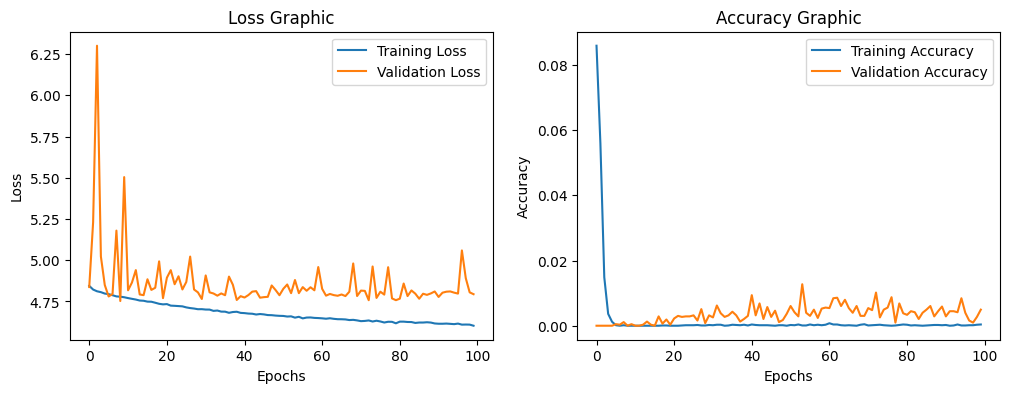

In [18]:
# Plotar o histórico do treinamento
plot_training_history(history_contrastive)

In [14]:
# Preparar os rótulos no formato one-hot para a classificação
print("\n--- Preparando dados para o classificador ---")
y_train_one_hot = tf.keras.utils.to_categorical(y_train_left_balanced, num_classes=2)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid_left_balanced, num_classes=2)
y_test_one_hot = tf.keras.utils.to_categorical(y_test_left, num_classes=2)

# Construir o modelo de classificação final
print("\n--- Construindo modelo de classificação ---")
encoder = build_encoder(input_shape)
classifier_model = build_classifier_model(encoder, num_classes=2)

# Carregar os melhores pesos do pré-treinamento no encoder
# Esta é a transferência de aprendizado.
print("\n--- Transferindo pesos do encoder pré-treinado ---")
try:
    # Construa um modelo temporário para carregar os pesos
    temp_contrastive_model = build_contrastive_pretrain_model(input_shape)
    temp_contrastive_model.load_weights('best_CNN_model.weights.h5')
    
    # Copie os pesos apenas do encoder
    encoder_weights = temp_contrastive_model.get_layer('encoder').get_weights()
    classifier_model.get_layer('encoder').set_weights(encoder_weights)
    
    print("Pesos do encoder transferidos com sucesso!")
except Exception as e:
    print(f"Não foi possível transferir os pesos. Erro: {e}. O modelo será treinado do zero.")

# 2.4. Treinar a cabeça de classificação (o encoder está congelado)
print("\n--- Iniciando treinamento do classificador final ---")
history_classifier = classifier_model.fit(
    train_left_balanced,
    y_train_one_hot,
    validation_data=(valid_left_balanced, y_valid_one_hot),
    epochs=30,
    batch_size=64,
)


--- Preparando dados para o classificador ---

--- Construindo modelo de classificação ---

--- Transferindo pesos do encoder pré-treinado ---
Pesos do encoder transferidos com sucesso!

--- Iniciando treinamento do classificador final ---
Epoch 1/30


c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - Precision: 0.6969 - Recall: 0.6969 - accuracy: 0.6969 - loss: 0.7702 - val_Precision: 0.7404 - val_Recall: 0.7404 - val_accuracy: 0.7404 - val_loss: 0.5950
Epoch 2/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - Precision: 0.7566 - Recall: 0.7566 - accuracy: 0.7566 - loss: 0.6032 - val_Precision: 0.7644 - val_Recall: 0.7644 - val_accuracy: 0.7644 - val_loss: 0.5795
Epoch 3/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - Precision: 0.7497 - Recall: 0.7497 - accuracy: 0.7497 - loss: 0.5771 - val_Precision: 0.7140 - val_Recall: 0.7140 - val_accuracy: 0.7140 - val_loss: 0.6413
Epoch 4/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - Precision: 0.7602 - Recall: 0.7602 - accuracy: 0.7602 - loss: 0.5542 - val_Precision: 0.7298 - val_Recall: 0.7298 - val_accuracy: 0.7298 - val_loss: 0.6015
Epoch 5/30
182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - Precision: 0.7567 - Recall: 0.7567 - accuracy: 0.7567 - loss: 0.5385 - val_Precision: 0.7333 - val_Recall: 0.733

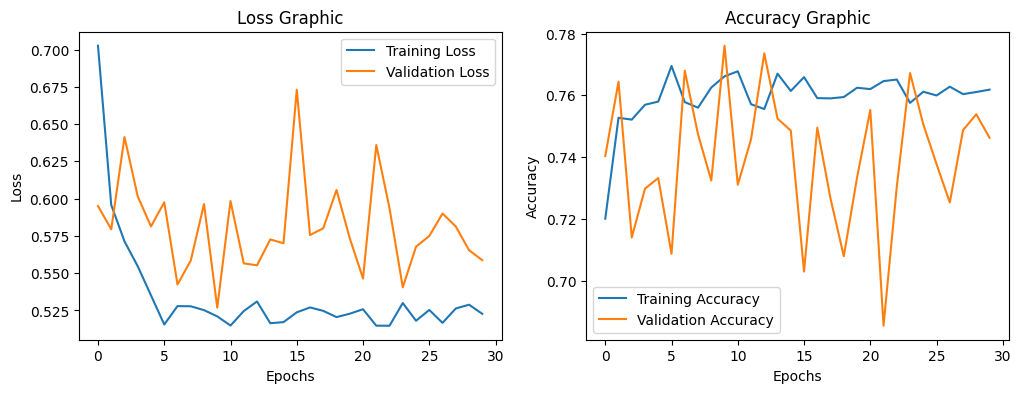

In [19]:
# Plotar o histórico do treinamento
plot_training_history(history_classifier)


--- Avaliando o modelo final no conjunto de teste ---
202/202 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

AUC da Curva Precision-Recall: 0.5000


c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


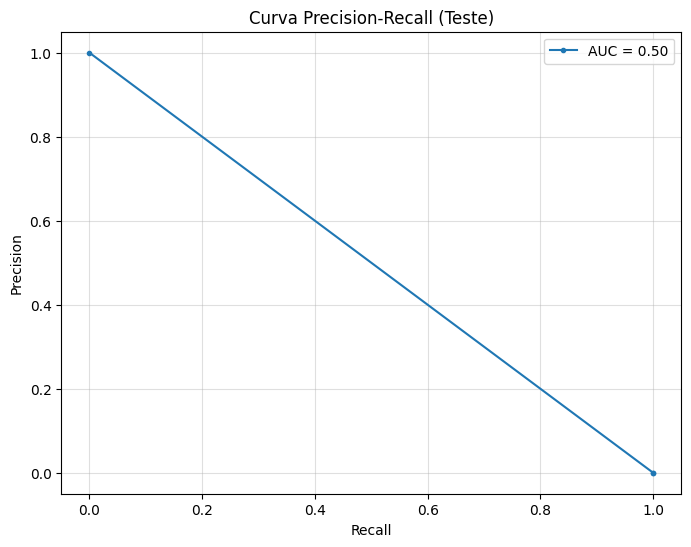

In [15]:
print("\n--- Avaliando o modelo final no conjunto de teste ---")

# Fazer predições no conjunto de validação e teste
y_pred_valid = classifier_model.predict(valid_left_balanced)
y_pred_test = classifier_model.predict(test_left)

# Para obter os labels (0 ou 1), usamos argmax
y_pred_valid = np.argmax(y_pred_valid, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Calcular e plotar a Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test_left, y_pred_test)
auc_pr = auc(recall, precision)

print(f"\nAUC da Curva Precision-Recall: {auc_pr:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (Teste)')
plt.legend(loc='best')
plt.grid(alpha=0.4)
plt.show()

In [16]:
# Gerar o relatório de classificação
print("Validação:")
print(classification_report(y_test_left, y_pred_test, target_names=['Classe 0', 'Classe 1']))
print("\n#########################################################\n")
print("Teste:")
print(classification_report(y_test_left, y_pred_test, target_names=['Classe 0', 'Classe 1']))

Validação:
              precision    recall  f1-score   support

    Classe 0       1.00      0.74      0.85      4703
    Classe 1       0.00      0.00      0.00         0

    accuracy                           0.74      4703
   macro avg       0.50      0.37      0.43      4703
weighted avg       1.00      0.74      0.85      4703


#########################################################

Teste:
              precision    recall  f1-score   support

    Classe 0       1.00      0.74      0.85      4703
    Classe 1       0.00      0.00      0.00         0

    accuracy                           0.74      4703
   macro avg       0.50      0.37      0.43      4703
weighted avg       1.00      0.74      0.85      4703



c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Gabriel Panza\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Validação:


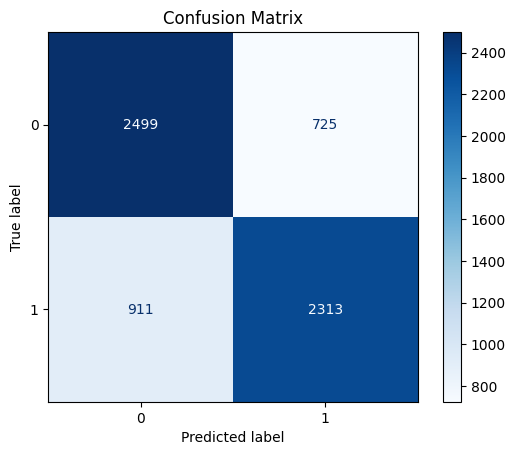

Teste:


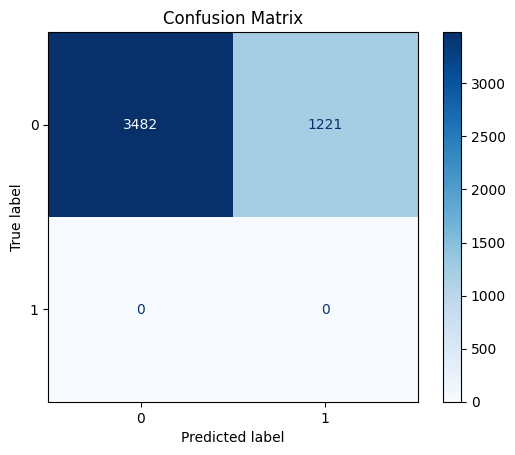

In [17]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(y_valid_left_balanced, y_pred_valid)
print("Teste:")
plot_confusion_matrix(y_test_left, y_pred_test)

##### Rodando processos de Pós-Processamento

In [ ]:
def load_patient_data_per_slice(folder, patient_id): # carregar dados de teste, mantendo os dados de cada fatia em um vetor
    patient_path = os.path.join(folder, patient_id)  # folder/patient/
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    labels_total = []
    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])  # folder/patient/left
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        os.listdir(path_left), os.listdir(lesion_path_left),
        os.listdir(path_right), os.listdir(lesion_path_right)
    ):
        img_path_left = os.path.join(path_left, patch_id_left)  # folder/patient/left/slice_
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)
        
        slice_left_img = []
        slice_right_img = []
        slice_left_mask = []
        slice_right_mask = []
        slice_left_labels = []
        slice_right_labels = []

        for img_left, msk_left, img_right, msk_right in zip(
            os.listdir(img_path_left), os.listdir(mask_path_left),
            os.listdir(img_path_right), os.listdir(mask_path_right)
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()

            if len(data_left) > 0 or len(data_msk_left) > 0:
                slice_left_img.append(data_left)
                slice_left_mask.append(data_msk_left)
                slice_left_labels.append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()

            if len(data_right) > 0 or len(data_msk_right) > 0:
                slice_right_img.append(data_right)
                slice_right_mask.append(data_msk_right)
                slice_right_labels.append(calculate_label(data_msk_right))

        patient_data["images_left"].append(slice_left_img)
        patient_data["mask_left"].append(slice_left_mask)
        patient_data["labels_left"].append(slice_left_labels)

        patient_data["images_right"].append(slice_right_img)
        patient_data["mask_right"].append(slice_right_mask)
        patient_data["labels_right"].append(slice_right_labels)

        labels_pair = []
        for label_left, label_right in zip(slice_left_labels, slice_right_labels):
            if label_left == 0 and label_right == 0:
                labels_pair.append(0)
            else:
                labels_pair.append(1)
        labels_total.append(labels_pair)

    patient_data["labels_pair"] = labels_total

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_total)}")
    return patient_data, labels_total

def test_labels_near(predictions): # pós-processamento
    new_pred = copy.deepcopy(predictions)
    previous_pos = 0
    actual_pos = 0
    next_pos = 0

    for i in range(1, len(predictions) - 1):

        # testa posições "perto", mas tá errado pela ordem dos recortes dentro da fatia
        for j in range(1, len(predictions[i])-1):
            if predictions[i][j] == 0 and predictions[i][j-1] == 1 and predictions[i][j+1] == 1:
                new_pred[i][j+1] = 0
                new_pred[i][j-1] = 0
                print(f"ANTES unit: {predictions[i]}")
                print(f"DEPOIS: {new_pred[i]}\n")

        # testa 3 fatias sequenciais
        previous_pos = np.count_nonzero(predictions[i - 1])
        actual_pos = np.count_nonzero(predictions[i])
        next_pos = np.count_nonzero(predictions[i + 1])

        if (previous_pos == 0 and actual_pos >= 1 and next_pos == 0):
            new_pred[i] = np.array([0 for j in range(len(predictions[i]))])
            print(f"ANTES whole: {predictions[i]}")
            print(f"DEPOIS: {new_pred[i]}\n")

    return new_pred

In [ ]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Novo_Contralateral"

# Lista de IDs dos pacientes
test_patient_ids = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

X_slices_left, X_slices_right, y_slices, mask_slices_left, mask_slices_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in test_patient_ids:
    # Carrega os dados do paciente
    patient_data_test, labels_pair_test = load_patient_data_per_slice(folder, patient_id)
    
    if patient_data_test is not None:
        X_slices_left[patient_id] = patient_data_test["images_left"]
        X_slices_right[patient_id] = patient_data_test["images_right"]
        mask_slices_left[patient_id] = patient_data_test["mask_left"]
        mask_slices_right[patient_id] = patient_data_test["mask_right"]
        y_slices[patient_id] = labels_pair_test

In [ ]:
# Normalização e tratamento de dimensões do dado de teste
test_single_left = {}
test_single_right = {}

for id in test_patient_ids:
    test_single_left[id] = []
    test_single_right[id] = []

    for i in range(0, len(X_slices_left[id])):
        test_single_left[id].append([])
        test_single_right[id].append([])

        for j in range(0, len(X_slices_left[id][i])):
            # print(f"Dados do paciente {id} da fatia {i} do dado {j} esquerdo")
            test_single_left[id][i].append(normalize_minmax(np.array(X_slices_left[id][i][j]))) # normaliza as imagens
            test_single_right[id][i].append(normalize_minmax(np.array(X_slices_right[id][i][j])))

        test_single_left[id][i] = np.expand_dims(test_single_left[id][i], axis=-1) # expande eixo pra passar rede pra predict
        test_single_right[id][i] = np.expand_dims(test_single_right[id][i], axis=-1)

In [ ]:
# Construir e compilar o modelo CNN
input_shape = (test_single_left[test_patient_ids[0]][0][0].shape)

siamese_model = build_siamese_model(input_shape)
siamese_model.summary()

# Carregando pesos da melhor época
siamese_model.load_weights('best_model.h5')

y_test_slices_pred = {}

for patient in test_patient_ids:
    print(f"paciente {patient}")
    y_test_slices_pred[patient] = []

    for i in range(0, len(X_slices_left[patient])):
        print(f"fatia {i}")
        left = test_single_left[patient][i]
        right = test_single_right[patient][i]
        y_test_slices_pred[patient].append((siamese_model.predict([left, right]) > 0.5).astype(int).flatten())

#### Comparando resultados sem e com Pós-Processamento

In [ ]:
# labels certos -> y_slices
# predição não processada -> y_test_slices_pred
# predição processada -> processed labels

processed_labels = {}

# crio um novo vetor com os labels processados
for patient_name in test_patient_ids:
    processed_labels[patient_name] = test_labels_near(y_test_slices_pred[patient_name])


In [ ]:
labels_pred_processed = list(itertools.chain(*list(itertools.chain(*processed_labels.values()))))

# Gerar a matriz de confusão
print("RESULTADO ORIGINAL:")
plot_confusion_matrix(y_test, y_pred_test)
print("\n#########################################################\n")
print("PÓS PROCESSADO:")
plot_confusion_matrix(y_test, labels_pred_processed)

# print(labels_true)
# print(labels_pred_raw)
# print(labels_pred_processed)

# print(np.count_nonzero(labels_true))
# print(np.count_nonzero(labels_pred_raw))
# print(np.count_nonzero(labels_pred_processed))

In [ ]:
print("Teste") 
print(classification_report(y_test, labels_pred_processed)) 

#### Plotando PDFs para comparação dos resultados e análise das classificações

In [ ]:
# Função para adicionar borda ao patch com a cor da classificação
def add_border(image, color, thickness=3):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    bordered_image = cv2.copyMakeBorder(image_rgb, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

def enhance_contrast(img, factor=1.1):
    img = img.astype(np.float32)
    img = img * factor
    return np.clip(img, 0, 255).astype(np.uint8)

# Função para carregar imagens no formato NIfTI (.nii.gz)
def load_nii_slice(patient_id, slice_index, base_path):
    file_path = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.nii.gz")
    if os.path.exists(file_path):
        nii_img = nib.load(file_path)
        img_data = nii_img.get_fdata()
        return img_data
    return None

# Função para carregar coordenadas de arquivos .txt
def load_coordinates(patient_id, slice_index, base_path):
    coord_file = os.path.join(base_path, patient_id, f"Slice_{slice_index:03d}.txt")
    if os.path.exists(coord_file):
        with open(coord_file, "r") as file:
            coordinates = [tuple(map(int, line.strip().split(","))) for line in file]
        return coordinates
    return []

# Função para reconstruir a imagem e sobrepor o grid
def build_image_with_grid(patient_id, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)
    
    if img is None or mask is None or not coordinates:
        return None, None, index

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)

    reconstructed_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    
    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    
    half = len(coordinates) // 2
    classifications = []

    for i in range(half):
        true = labels_true[i + index]
        pred = labels_pred[i + index]
        if pred == true:
            classif = "TP" if pred == 1 else "TN"
        else:
            classif = "FP" if pred == 1 else "FN"
        classifications.append(classif)
    
    # Repetir a classificação para o lado direito
    classifications.extend(classifications)

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        classif = classifications[i]

        patch_img = img[y1+3:y2-3, x1+3:x2-3]
        patch_mask = mask[y1+3:y2-3, x1+3:x2-3]

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask, (index + half)

# Reconstrói uma fatia do paciente usando coordenadas + indexes mapeados
def build_image_with_grid_indexed(patient_id, slice_index, balanced_index_patients,
                                  labels_pred, labels_true, image_path, mask_path,
                                  coordinates_path, patch_metadata):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)

    if img is None or mask is None or not coordinates:
        return None, None

    img = enhance_contrast(img)
    mask = enhance_contrast(mask)
    
    height, width = img.shape[:2]
    reconstructed_img = np.zeros((height, width, 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((height, width, 3), dtype=np.uint8)

    colors = {"TP": (0, 255, 0), "TN": (120, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        # Identifica o global_index da coordenada
        global_index = None
        for idx, meta in patch_metadata.items():
            if meta[0] == patient_id and meta[1] == slice_index and meta[3:] == (y1, y2, x1, x2):
                global_index = idx
                break

        if global_index in balanced_index_patients:
            label_pos = balanced_index_patients.index(global_index)
            true_label = labels_true[label_pos]
            pred_label = labels_pred[label_pos]

            if pred_label == true_label:
                classif = "TP" if pred_label == 1 else "TN"
            else:
                classif = "FP" if pred_label == 1 else "FN"

            patch_img = img[y1+3:y2-3, x1+3:x2-3]
            patch_mask = mask[y1+3:y2-3, x1+3:x2-3]
        else:
            classif = "TN"
            patch_img = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)
            patch_mask = np.zeros((y2 - y1 - 6, x2 - x1 - 6), dtype=np.uint8)

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask

# Gera metadados global_index → (patient, slice, side, y1, y2, x1, x2)
def generate_patch_metadata(patients, coordinates_path):
    patch_metadata = {}
    global_index = 0
    for patient in patients:
        patient_dir = os.path.join(coordinates_path, patient)
        if not os.path.isdir(patient_dir):
            continue
        for filename in sorted(os.listdir(patient_dir)):
            if filename.endswith(".txt"):
                slice_index = int(filename.split("_")[1].split(".")[0])
                coord_file = os.path.join(patient_dir, filename)
                with open(coord_file, "r") as f:
                    coords = [tuple(map(int, line.strip().split(","))) for line in f if line.strip()]
                half = len(coords) // 2
                for i, (y1, y2, x1, x2) in enumerate(coords):
                    side = 'left' if i < half else 'right'
                    patch_metadata[global_index] = (patient, slice_index, side, y1, y2, x1, x2)
                    global_index += 1
    print(f"✅ Mapeamento gerado com {len(patch_metadata)} patches.")
    return patch_metadata


In [ ]:
def plot_patient_slices(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-42B05': 1204, 'sub-42K06': 1122, 'sub-44H05': 1213, 'sub-86G08': 1189}
plot_patient_slices(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Uppersampling+Undersampling.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

In [ ]:
def plot_nifti_patient_slices_with_borders_and_masks(
    pdf_folder, patients, coordinates_path, image_path, mask_path,
    labels_true, labels_pred, balanced_index_patients
):
    os.makedirs(pdf_folder, exist_ok=True)

    patch_metadata = generate_patch_metadata(patients, coordinates_path)

    # Mapeia slices por paciente
    slices_por_paciente = {}
    for idx, (patient_id, slice_idx, _, _, _, _, _) in patch_metadata.items():
        slices_por_paciente.setdefault(patient_id, set()).add(slice_idx)

    for patient in patients:
        if patient not in slices_por_paciente:
            continue

        slice_indices = sorted(slices_por_paciente[patient])
        patient_folder = os.path.join(pdf_folder, patient)
        os.makedirs(patient_folder, exist_ok=True)
        pdf_filename = os.path.join(patient_folder, f"Paciente_{patient}.pdf")

        with PdfPages(pdf_filename) as pdf:
            for slice_idx in slice_indices:
                img_reconstructed, mask_reconstructed = build_image_with_grid_indexed(
                    patient_id=patient,
                    slice_index=slice_idx,
                    balanced_index_patients=balanced_index_patients,
                    labels_pred=labels_pred,
                    labels_true=labels_true,
                    image_path=image_path,
                    mask_path=mask_path,
                    coordinates_path=coordinates_path,
                    patch_metadata=patch_metadata
                )

                if img_reconstructed is None or mask_reconstructed is None:
                    continue

                fig, axs = plt.subplots(2, 1, figsize=(8, 12))
                axs[0].imshow(img_reconstructed)
                axs[0].set_title(f"Reconstrução com Classificação - {patient} - Slice {slice_idx:03d}")
                axs[0].axis("off")

                axs[1].imshow(mask_reconstructed)
                axs[1].set_title("Máscara Correspondente")
                axs[1].axis("off")

                pdf.savefig(fig)
                plt.close(fig)

        print(f"✅ PDF salvo: {pdf_filename}")

    print(f"\n📁 Todos os PDFs foram salvos em: {pdf_folder}")

# plot_nifti_patient_slices_with_borders_and_masks(
#     pdf_folder="Pdf_Final_NIfTI_Reconstruido",
#     patients=train_patients,
#     coordinates_path="Coordenadas_grid",
#     image_path="Fatias",
#     mask_path="Mask_Fatias",
#     labels_true=y_train_balanced,
#     labels_pred=y_pred_train,
#     balanced_index_patients=balanced_index_patients
# )

plot_nifti_patient_slices_with_borders_and_masks(
    pdf_folder="Pdf_Final_NIfTI_Reconstruido",
    patients=valid_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid,
    balanced_index_patients=balanced_index_patients
)

In [ ]:
def plot_patient_slices_paired(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            for slice_index in range(test_patients_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, index)
                
                if img_recon is None:
                    continue
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_patients_quantity = {'sub-42B05': 1204, 'sub-42K06': 1122, 'sub-44H05': 1213, 'sub-86G08': 1189}
plot_patient_slices_paired(
    pdf_filename="Pdf_SNN/Pacientes_Test_Reconstruidos_Com_Pareamento.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=y_test,
    labels_pred=y_pred_test,
)

In [ ]:
def plot_patient_patches_paired(pdf_filename, patients, images_left, images_right, masks_left, masks_right, labels_true, labels_pred, balanced_index_by_patients, type):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)

    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:
            print(f"\n🔍 Paciente: {patient}")
            indices = paired_index_dictionary[type].get(patient, [])
            print(f"📊 Número de pares: {len(indices)}")

            for i in range(len(indices)):
                colors = {"TP": (0, 255, 0), "TN": (150, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}

                # Calcula a classificação
                true_label = labels_true[index]
                pred_label = labels_pred[index]
                if pred_label == true_label:
                    classification = "TP" if pred_label == 1 else "TN"
                else:
                    classification = "FP" if pred_label == 1 else "FN"

                color = colors[classification]

                # Pega patches esquerdo e direito e máscaras pelos arrays alinhados
                patch_left = images_left[index]
                patch_right = images_right[index]
                mask_l = masks_left[index]
                mask_r = masks_right[index]

                # Aplica bordas
                bordered_patch_left = add_border(patch_left, color)
                bordered_patch_right = add_border(patch_right, color)
                bordered_mask_left = add_border(mask_l, color)
                bordered_mask_right = add_border(mask_r, color)

                # Plotagem
                fig, axs = plt.subplots(2, 2, figsize=(6, 6))
                axs[0, 0].imshow(bordered_patch_left)
                axs[0, 0].set_title("Img Esq")
                axs[0, 1].imshow(bordered_patch_right)
                axs[0, 1].set_title("Img Dir")
                axs[1, 0].imshow(bordered_mask_left)
                axs[1, 0].set_title("Mask Esq")
                axs[1, 1].imshow(bordered_mask_right)
                axs[1, 1].set_title("Mask Dir")

                for ax in axs.flat:
                    ax.axis('off')

                fig.suptitle(f"Paciente: {patient} | {classification}", fontsize=10)
                pdf.savefig(fig)
                plt.close(fig)

                index += 1

        print(f"Patches com bordas salvos em {pdf_filename}")

plot_patient_patches_paired(
    pdf_filename="Pdf_SNN/Train_Patches_SemReconstrucao_Pareamento.pdf",
    patients=train_patients,
    images_left=train_left_balanced,
    images_right=train_right_balanced,
    masks_left=mask_train_left,
    masks_right=mask_train_right,
    labels_true=y_train_balanced,
    labels_pred=y_pred_train,
    balanced_index_by_patients=paired_index_dictionary['train'],
    type = 'train'
)

plot_patient_patches_paired(
    pdf_filename="Pdf_SNN/Valid_Patches_SemReconstrucao_Pareamento.pdf",
    patients=valid_patients,
    images_left=valid_left_balanced,
    images_right=valid_right_balanced,
    masks_left=mask_valid_left,
    masks_right=mask_valid_right,
    labels_true=y_valid_balanced,
    labels_pred=y_pred_valid,
    balanced_index_by_patients=paired_index_dictionary['val'],
    type = 'val'
)
